In [1]:
from data_loader import get_loader
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.utils.data as data

In [22]:
# Training Configuration
image_root = "./../../../datasets/cs253-wi20-public/ShapeNetRendering/"
point_cloud_root = "./../../../datasets/cs253-wi20-public/ShapeNet_pointclouds/"


batch_size = 4
shuffle = True
num_workers = 8
use_2048 = True
img_size = 100
transform = transforms.Compose([transforms.Resize(img_size,interpolation=2),transforms.CenterCrop(img_size)])


In [23]:
# p = './../../../datasets/cs253-wi20-public/ShapeNetRendering/02691156/10155655850468db78d106ce0a280f87/rendering/00.png'

In [24]:
data_loader = get_loader(image_root, point_cloud_root, use_2048, transform, batch_size, shuffle, num_workers)

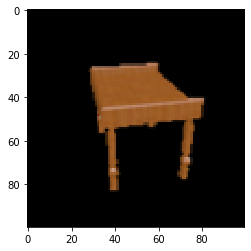

In [33]:
from matplotlib import pyplot as plt
import numpy as np

for i, (images, point_clouds) in enumerate(data_loader):
    # Show image and print point cloud.
    #     print(type(image))
#     print(images.size())
    
    image = images[0]
    pc = point_clouds[0]
    
    plt.imshow(image)

    
    break
    

In [1]:
from split_data import split_data, read_from_file

In [2]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [3]:
split_data(train_ratio, val_ratio, test_ratio, overrideFiles = False)

In [4]:
import numpy as np

l = np.arange(1, 10, 1)

s = set(l)
print(s)

{1, 2, 3, 4, 5, 6, 7, 8, 9}


In [5]:
p = np.arange(11, 20, 1)

lp = [(l[t],p[t]) for t in range(len(l))]
print(lp)

[(1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 16), (7, 17), (8, 18), (9, 19)]


In [6]:
lps = set(lp)

(1,10) in lps

False

In [8]:
train_data = read_from_file('train_data.txt')

In [10]:
for i, s in train_data:
    print(i), print(s)
    break
    

02958343
f6d7cd8a000997b1aa69dfdc5532bb13


In [2]:

import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from chamfer_distance import ChamferDistance
from torch.autograd import Variable
import glob
import torch.nn.functional as F
from models import Encoder, Tnet, Decoder

In [3]:
l = glob.glob("/datasets/cs253-wi20-public/ShapeNet_pointclouds/*/*/*2048.npy")

class PointCloudDataset(Dataset):

    def __init__(self, lis= None):
        
        point_clouds = []
        for file_name in lis:

            points = np.load(file_name)
            point_clouds.append(points)

        self.point_clouds = np.array(point_clouds, dtype='float64')
        self.point_clouds = np.transpose(self.point_clouds, (0, 2, 1))
        
    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        return self.point_clouds[idx]

In [4]:
point_cloud_dataset = PointCloudDataset(l)
dataloader = DataLoader(point_cloud_dataset, batch_size=32, shuffle=True)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

inp  = next(iter(dataloader)).float()

baseline = torch.load('best-Baseline.pt')

baseline = baseline.cuda()

# train_output = enc(inp.cuda().float())
out= baseline(inp.cuda().float())
for i in range(4):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    data = inp[i].numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='b', label='ground truth')
    data = out[i].cpu().detach().numpy()
    ax = fig.add_subplot(2, 4, i+5, projection='3d')
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='r', label='decoded')
    
ax.legend()
plt.show()

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 3 3 1 1, but got 3-dimensional input of size [32, 3, 2048] instead

<Figure size 432x288 with 0 Axes>

In [1]:
import glob

image_root = "/datasets/cs253-wi20-public/ShapeNetRendering/"

syn_list = glob.glob(image_root+"*/*/rendering/*.png")


In [4]:
import random
from PIL import Image

N = len(syn_list)
image = Image.open(syn_list[random.randint(0, N-1)]).convert('RGB')


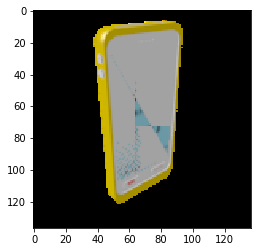

In [7]:
import matplotlib.pyplot as plt


plt.imshow(image)
plt.show()

In [8]:
point_cloud_root = "/datasets/cs253-wi20-public/ShapeNet_pointclouds/"

pc_list = glob.glob(point_cloud_root+"*/*/*2048.npy")


In [9]:
len(pc_list)

43784

In [12]:
import numpy as np

index = 0

point_cloud = np.load(pc_list[index])

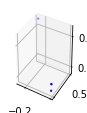

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(2, 4, 1, projection='3d')

data= point_cloud

ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='b', label='ground truth')


In [14]:
img_pc = Image.fromarray(point_cloud, 'RGB')

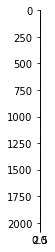

In [16]:
plt.imshow(img_pc)
plt.show()

In [17]:
point_cloud.shape

(2048, 3)